<a href="https://colab.research.google.com/github/KravitzLab/PsygeneAnalyses/blob/PCA_analysis/Kravitz_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PCA plotting for PsyGene Mice Behavior

In [1]:
#@title # Import Libraries

####### Import Needed Libraries #######
# Libraries for Machine Learnings/Modeling
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.model_selection import train_test_split
# Libraries for importing
import zipfile
from google.colab import files # creates the ability for display uploads
import tempfile
import io
import os
# Data Frame libraries
import pandas as pd
import numpy as np
# for merging
from functools import reduce

from decorator import DEF

import ipywidgets as widgets

In [85]:
#@title # Define functions used through out the script

####### DEFINE ALL FUNCTIONS #######

### Session type Extraction ###
# This code will extract the "session_type" column from each file
def extract_session_type(df, file_name, fallback="Unknown"):
    # Follow Naming conventions so far
    session_types = ["weight", "bandit100", "fr1", "beam", "bandit80",
                     "_pr_", # we have to define pr surrounded by underscores to prevent random pr's
                     "individual_behavoir", "social_interaction", "nesting"]
    """Read 'Session_Type ' or variants; return first non-empty value."""
    file_name = file_name.lower()
    print(f"Extracting session type for file: {file_name}")
    try:
        #df = pd.read_csv(csv_path, sep=None, engine='python', dtype=str)
        df = df
        df.columns = [c.strip() for c in df.columns]
        lower = {c.casefold(): c for c in df.columns}
        # Loop through common session like column names
        for cand in ["session_type", "session type", "sessiontype", "session"]:
            if cand in lower:
                col = lower[cand]
                vals = df[col].dropna().astype(str).str.strip()
                vals = vals[vals.ne("")]
                if not vals.empty:
                    return vals.iloc[0].lower()
            else:
              # use the file name to determine what session type it is
              matches = [c for c in session_types if c.lower() in file_name.lower()]
              return(matches[0])

    except Exception as e:
        print(f"Error reading {csv_path}: {e}")
    return fallback

### Retrieve dataframe profiles ###
# expects a dataframe as an argument
def df_prof(df):
  # Get Dimensions
  print(f"Number of rows: {df.shape[0]}")
  print(f"Number of columns: {df.shape[1]}")

  # Data types
  df_prof = df.dtypes.rename("DataType")

  # Null percentages
  df_null = (df.isna().sum() / len(df) * 100).rename("Percent_Null")

  # unique counts
  df_uniq = df.nunique().rename("Number_Unique")

  # Merge into one DataFrame
  merged_df = pd.concat([df_prof, df_null, df_uniq], axis=1).reset_index()
  merged_df.columns = ["Column", "DataType", "Percent_Null", "Number_Unique"]
  print(merged_df)



### Define easy function for finding mode ###
def mode_or_nan(x):
    # handle ties or empty groups safely
    return x.mode().iloc[0] if not x.mode().empty else None


### Aggregate Session Dataframes ###
# expects dictionary containing dataframes
# Requires "Mouse_ID" Column
# Will iterate through dataframes within the session dictionary passed
#     and aggregate by Mouse_ID and ensure only 1 mouse is represented.
# define this as a function for better readbility and to easily adjust
#   drop lists
def aggregate_session_types(session_dfs):
    # Iterate across the session dictionary
    for s, d in session_dfs.items():
        print(f"Aggregating Session Type: {s}")

        # Check to see if primary key is same length as number of rows in dataframe
        if len(d) == d["Mouse_ID"].nunique():
            print("Number of Mice equal to Length of dataframe: No Aggregation Needed")
            continue

        # Define numeric and categorical columns
        numeric_cols = d.select_dtypes(include=['int64', 'float64']).columns
        object_cols = d.select_dtypes(include=['object', 'category', 'datetime64']).columns

        # perform aggregation
        agg_dict = {
            **{col: 'mean' for col in numeric_cols},
            **{col: mode_or_nan for col in object_cols}
        }

        session_dfs[s] = (d.groupby('Mouse_ID', dropna=False, as_index=False)
                          .agg(agg_dict))
    return session_dfs



### Clean Session Dataframes ###
# Very fragile and expects the user to do manual investigation
# could add detection for columns with null values
# define this as a function for better readbility and to easily adjust
#   drop lists
def clean_session_types(session_dfs, all_drops, percent_drop = 5):
  # Interate through large table and remove
  for s, d in session_dfs.items():
    print(f"Cleaning Session Type: {s}")

    # remove "$" from column names
    session_dfs[s].columns = session_dfs[s].columns.str.replace('$', '')

    ### Conduct general data cleaning ###
    session_dfs[s] = session_dfs[s].drop(columns = all_drops, errors='ignore')

    # Calculate the percentage of null values for each column
    null_percentages = session_dfs[s].isnull().sum() * 100 / len(session_dfs[s])

    # Identify columns where the null percentage is greater than 5%
    columns_to_drop = null_percentages[null_percentages > percent_drop].index

    # Drop the identified columns from the DataFrame
    session_dfs[s] = session_dfs[s].drop(columns=columns_to_drop)

    ### Add suffix if doesnt exist ###
    # set to lowercase
    session_dfs[s].columns = session_dfs[s].columns.str.lower()

    # Columns to not add suffix
    exceptions = ["mouse_id", "sex", "genotype", "gene", "session_type"]

    session = session_dfs[s]["session_type"].iloc[0]
    session_dfs[s].rename(
    columns=lambda c: f"{c}_{session}"
                      if (c not in exceptions and c not in exceptions and not c.endswith(f"_{session}"))
                      else c,
    inplace=True
    )
    """
    ### Clean bandit80 specific data ###
    if s.lower() in ["bandit80", "bandit100"]:
      session_dfs[s] = session_dfs[s].drop(columns = bandit_drops, errors='ignore')
      # Ensure date times are correct data type
      session_dfs[s]['FED_StartDate'] = pd.to_datetime(session_dfs[s]['FED_StartDate'])

    ### Clean weight specific data ###
    if s.lower() in ["weight"]:

      session_dfs[s] = session_dfs[s].drop(columns = weight_drops, errors='ignore')
      # Ensure date times are correct data type
      session_dfs[s]['DOB'] = pd.to_datetime(session_dfs[s]['DOB'])

    # remove session type after all the cleaning
    session_dfs[s] = session_dfs[s].drop(columns = "session_type", errors='ignore')
  """
  ### Return the session_dfs ###
  return(session_dfs)





In [86]:
#@title # Import Wanted Data Files
#@markdown Code based on Chantelle Murelle and Sebastian Alves\
#@markdown The following code will iteritvly read all csv's within the
#@markdown zipped file and seperate them into a dictionary based on the various
#@markdown recordings. this will be used for processing the data in a session type manner.\
#@markdown This could include L3 for all various recordings:
#@markdown 1.   Weight
#@markdown 2.   Bandit100_0
#@markdown 3.   FR1
#@markdown 4.   BEAM
#@markdown 5.   Bandit80_20
#@markdown 6.   PR
#@markdown 7.   Individual Behavoir
#@markdown 8.   Social Interaction
#@markdown 9.   Nesting




####### Import Wanted Data Files ########
# Code based on Chantelle Murelle and Sebastian Alves

### reset cache ###
# Reset caches to avoid duplicates if you re-run this cell
session_dict, loaded_files, session_types = [], [], []

### Define the upload UI element ###
uploaded = files.upload()

### Create Data dictonary and containers ###
session_dict = {} # for storing by session type
loaded_files = [] # for files

### Loop through the uploaded files ###
# This expects a zippped file exclusivly
for name, data in uploaded.items():
  with zipfile.ZipFile(io.BytesIO(data)) as zf: # use zipfile to "unzip"
    for zi in zf.infolist(): # iterate through the zipped files


      # skip non handled file types
      # Skip non-csv/xlsx files
      if not (zi.filename.endswith(".csv") or zi.filename.endswith(".xlsx")):
        print(f"Skipping: {zi.filename}")
        continue
      print(f"\nProcessing: {zi.filename}")

      # define filetype
      file_type = "csv" if zi.filename.endswith(".csv") else "xlsx"

      # read the file in
      file_data = zf.read(zi)

      # write temporary file into memory
      suffix = ".csv" if file_type == "csv" else ".xlsx"
      with tempfile.NamedTemporaryFile(mode="w+b", suffix=suffix, delete=False) as tmp:
        tmp.write(file_data)
        tmp_path = tmp.name

      # Define try catch statment and read into memory
      try:
        if file_type == "csv":
          df = pd.read_csv(tmp_path)
        else:
          df = pd.read_excel(tmp_path)
        #df["source_file"] = zi.filename
        session_type = extract_session_type(df, zi.filename)
        # rewrite session
        df["session_type"] = session_type
        print(session_type)

        # Add to the data dictionary based on session type
        if session_type not in session_dict:
          session_dict[session_type] = []
        session_dict[session_type].append(df)
      except Exception as e: # throw error on failure to load
        print(f"Error loading {zi.filename}: {e}")
      finally: # remove the temporary path
        os.remove(tmp_path)



### Combine dataframes for each session ###
# Convert each list of dfs into one merged dataframe per session type
session_dfs = {k: pd.concat(v, ignore_index=True) for k, v in session_dict.items()}

#session_dfs.pop('weight', None)
#session_dfs.pop('bandit100', None)
#session_dfs.pop('beam', None)
session_dfs.pop('si', None)

#print(session_dfs['bandit100'])

### Return overarcing view of all sessiont types ###
for s, d in session_dfs.items():
    print(f"\nSession '{s}' → {d.shape[0]} rows, {d.shape[1]} cols")
    df_prof(session_dfs[s])

Saving all_l3.zip to all_l3 (5).zip
Skipping: all_l3/

Processing: all_l3/CDKL5_005_Bandit100_L3_wbr.csv
Extracting session type for file: all_l3/cdkl5_005_bandit100_l3_wbr.csv
bandit80

Processing: all_l3/CDKL5_005_Bandit80_L3_wbr.csv
Extracting session type for file: all_l3/cdkl5_005_bandit80_l3_wbr.csv
bandit80

Processing: all_l3/CDKL5_005_FR1_L3_vwbr.csv
Extracting session type for file: all_l3/cdkl5_005_fr1_l3_vwbr.csv
fr1

Processing: all_l3/combined_beam_spectral.csv
Extracting session type for file: all_l3/combined_beam_spectral.csv
beam

Processing: all_l3/DNMT3a_002_Bandit100_L3_wbr.csv
Extracting session type for file: all_l3/dnmt3a_002_bandit100_l3_wbr.csv
bandit100

Processing: all_l3/DNMT3a_002_Bandit80_L3_wbr.csv
Extracting session type for file: all_l3/dnmt3a_002_bandit80_l3_wbr.csv
bandit80

Processing: all_l3/DNMT3A_002_FR1_L3_vwbr.csv
Extracting session type for file: all_l3/dnmt3a_002_fr1_l3_vwbr.csv
fr1

Processing: all_l3/DNMT3A_002_PR1_L3_vwbr.csv
Extracting ses

In [87]:
# @title # Begin to clean data.
# @markdown Define what columns for what seesion types will be dropped.
# @markdown This should be based on nullness and should seek to keep as
# @markdown large an N as possible. Additionally, columns that are believe
# @markdown to add little to no context could be dropped.

####### BEGIN DATA CLEANING AND SCRUBBING #######


# drop known problem columns
all_drops = ["filename", "filename_md", "Session_type", "match_status",
               "Primary", "Autoexcluder", "Gene_ID"]



dfs_agg = aggregate_session_types(session_dfs)


dfs_clean = clean_session_types(session_dfs=dfs_agg,
                                all_drops=all_drops)


### Return overarcing view of all sessiont types ###
for s, d in dfs_clean.items():
    print(f"\nSession '{s}' → {d.shape[0]} rows, {d.shape[1]} cols")
    df_prof(dfs_clean[s])




Aggregating Session Type: bandit80
Aggregating Session Type: fr1
Number of Mice equal to Length of dataframe: No Aggregation Needed
Aggregating Session Type: beam
Number of Mice equal to Length of dataframe: No Aggregation Needed
Aggregating Session Type: bandit100
Number of Mice equal to Length of dataframe: No Aggregation Needed
Aggregating Session Type: pr1
Number of Mice equal to Length of dataframe: No Aggregation Needed
Aggregating Session Type: weight
Number of Mice equal to Length of dataframe: No Aggregation Needed
Aggregating Session Type: bandit100_rl
Number of Mice equal to Length of dataframe: No Aggregation Needed
Aggregating Session Type: bandit80_rl
Number of Mice equal to Length of dataframe: No Aggregation Needed
Cleaning Session Type: bandit80
Cleaning Session Type: fr1
Cleaning Session Type: beam
Cleaning Session Type: bandit100
Cleaning Session Type: pr1
Cleaning Session Type: weight
Cleaning Session Type: bandit100_rl
Cleaning Session Type: bandit80_rl

Session 'b

In [88]:
# @title # Merge and Prepare Columns
# @markdown Continues cleaning and data formatting including:
# @markdown 1. Remove any rows that have any null values present.
# @markdown 2. Number of Days columns (if date times are present).




####### Merge the list of dataframes #######

# Define the features that will be merged on
merge_keys = ["mouse_id", "gene", "sex", "genotype"]

# Define columns for metadata
meta_rows = []

# ensure all key columns are normalized
for s, d in dfs_clean.items():
    dfs_clean[s][merge_keys] = dfs_clean[s][merge_keys].astype(str).apply(lambda col: col.str.upper())

    # Build meta data file
    # extract the session type (assume same for all rows)
    session = dfs_clean[s]["session_type"].iloc[0]
    # take all columns *except* session_type
    cols = dfs_clean[s].columns.drop("session_type")
    # add metadata rows
    for c in cols:
        meta_rows.append({"column_name": c, "session_type": session})

# Create the meta datafrane linking all session types to features
df_meta = pd.DataFrame(meta_rows)
df_meta = df_meta[~df_meta["column_name"].isin(merge_keys)]

print(f"Meta data frame: \n{df_meta}")



# Merge files
merged = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=merge_keys,
        how="outer",
        suffixes=("", "_dup")
    ),
    dfs_clean.values()
)


### Remove any rows that contain null values ###
# Replace textual 'nan' with real NaN and assign
replaced = merged.replace('nan', np.nan)
# Keep only rows that have NO nulls in any column
df_all = replaced[~replaced.isnull().any(axis=1)].reset_index(drop=True)


### Deal with the dates ###
# by representing how old each mouse is (days) for various tasks
dob_col = df_all.columns[df_all.columns.str.contains("dob")]
if not dob_col.empty:
  # Extract column
  dob_col = dob_col[0]
  print(f"Found DOB Column: {dob_col} \nCalculating days old for tasks")
  fed_starts = df_all.columns[df_all.columns.str.contains("FED_StartDate")]

  # Convert DOB column once to datetime
  dob_dt = pd.to_datetime(df_all[dob_col], errors='coerce')

  # Loop through each FED_StartDate column and calculate days difference
  for fed_col in fed_starts:
    new_col_name = f"days_old_for_{fed_col}"
    df_all[new_col_name] = (
        pd.to_datetime(df_all[fed_col], errors='coerce') - dob_dt
        ).dt.days
    print(f"→ Created column: {new_col_name}")


### Remove any datetime columns ###
datetime_cols = df_all.select_dtypes(include=['datetime64']).columns
df_all.drop(columns = datetime_cols, inplace=True)


### Check the data ###
print(df_all.columns.values)
df_prof(df_all)
#df_all.head()




# ---------- Save CSV ----------
#csv_name = f"PRmetrics_{datetime.now():%Y%m%d_%H%M%S}.csv"
csv_name = f"all_merged_dataframes.csv"

down_df = df_all.to_csv(csv_name, index=False)
#display(HTML(f"<b>✓ Saved PR metrics CSV to:</b> <code>{csv_name}</code>"))

try:
    from google.colab import files as gfiles
except Exception:
    gfiles = None

# Optional download button (works in Colab)
btn = widgets.Button(description=f"Download {os.path.basename(csv_name)}", icon="download")
status = widgets.HTML()
def _dl(_):
    if gfiles is not None:
        status.value = f"Starting download: <code>{os.path.basename(csv_name)}</code>…"
        gfiles.download(csv_name)
    else:
        status.value = f"Saved locally at <code>{csv_name}</code>."
display(btn, status)
btn.on_click(_dl)

Meta data frame: 
                column_name session_type
0             beam_bandit80     bandit80
1         win-stay_bandit80     bandit80
2       lose-shift_bandit80     bandit80
3     peakaccuracy_bandit80     bandit80
4    total_pellets_bandit80     bandit80
..                      ...          ...
178       alpha_bandit80_rl  bandit80_rl
179        beta_bandit80_rl  bandit80_rl
180        bias_bandit80_rl  bandit80_rl
181       lapse_bandit80_rl  bandit80_rl
182   best_loss_bandit80_rl  bandit80_rl

[155 rows x 2 columns]
Found DOB Column: dob_pr1 
Calculating days old for tasks
['beam_bandit80' 'win-stay_bandit80' 'lose-shift_bandit80'
 'peakaccuracy_bandit80' 'total_pellets_bandit80' 'total_pokes_bandit80'
 'pokesperpellet_bandit80' 'retrievaltime_bandit80' 'poketime_bandit80'
 'daily pellets_bandit80' 'win-stay_day_bandit80'
 'win-stay_night_bandit80' 'lose-shift_day_bandit80'
 'lose-shift_night_bandit80' 'peakaccuracy_day_bandit80'
 'peakaccuracy_night_bandit80' 'mouse_id' 'g

Button(description='Download all_merged_dataframes.csv', icon='download', style=ButtonStyle())

HTML(value='')

In [97]:
# @title # Prepare data for multiple ML approaches
# @markdown Should prepare data in theory for a RandomForestModel\
# @markdown This will include:
# @markdown 1. One-hot Encoding
# @markdown 2. Split into Training and Testing datasets
# @markdown 3. Normalization of data



from sklearn.preprocessing import LabelEncoder
### Define the classifier for prediction ###
pred_col = ["gene"]

### Define known categorical columns ###
known_objects = ["sex", "genotype"]

### Remove date-time columns ###
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
# Drop the datetime columns
df_no_datetime = df.drop(columns=datetime_cols)

# Drop problem columns
columns_to_drop = [col for col in df_all.columns if
                   not (col.startswith('stim_partner')
                   or col.startswith('fed3_')
                   or col.startswith('fed_')
                   or col.startswith('dob_')
                   or col.startswith('session_type')
                   or col.startswith('time_of_min_')
                   or col.startswith('time_of_max_peak_')
                   or col.startswith('beam_time_of')
                   or col.startswith('unnamed')
                   )]
df_all = df_all[columns_to_drop]


### Cast categorical columns ###
df_all[known_objects] = df_all[known_objects].astype('object')




### Begin encoding ###

# encode multiclass prediciton
le = LabelEncoder()
df_all["gene"] = le.fit_transform(df_all["gene"])


# Define ID columns (Columns to Drop)
id_cols = ["mouse_id"]
id_cols.extend(pred_col)


# Define X and y
y = df_all[pred_col] # Currently not encoded
print(y)

X = df_all.drop(columns=id_cols)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify categorical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# One-hot encode categorical features
print(f"One-hot encoding the following columns: {list(cat_cols)}")
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True, dtype=bool)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True, dtype=bool)

# Align columns between train and test
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Scale data
# find numeric
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
# find boolean
bool_cols = X_train.select_dtypes(include=['bool']).columns


# fit to only training
scaler.fit(X_train[num_cols])

X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


"""
# Run lasso to determine linked features
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
selected_features = coefficients[coefficients != 0].index.tolist()
print(selected_features)

# Return only selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]
"""


# Glimpse training data
X_train.head()
print(df_prof(X_train))

     gene
0       0
1       0
2       0
3       0
4       0
..    ...
117     3
118     3
119     3
120     3
121     3

[122 rows x 1 columns]
One-hot encoding the following columns: ['genotype', 'sex']
Number of rows: 85
Number of columns: 143
                     Column DataType  Percent_Null  Number_Unique
0             beam_bandit80  float64           0.0             52
1         win-stay_bandit80  float64           0.0             84
2       lose-shift_bandit80  float64           0.0             78
3     peakaccuracy_bandit80  float64           0.0             72
4    total_pellets_bandit80  float64           0.0             65
..                      ...      ...           ...            ...
138       lapse_bandit80_rl  float64           0.0             61
139   best_loss_bandit80_rl  float64           0.0             85
140            genotype_HOM     bool           0.0              2
141             genotype_WT     bool           0.0              2
142                   sex_M 

In [98]:
#@title # Tune hyperparameters for Random Forest Modeling

# tune hyperparameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso


# Define RF
rf = RandomForestClassifier()


param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 1) Your Code Below
# initialize the stratified fold
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)


grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid_rf,
    scoring = "roc_auc_ovr",
    cv = cv,
    n_jobs = 1
)

grid_search.fit(X_train, y_train)

#grid_search
print(grid_search.best_params_)
print(grid_search.best_score_)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
0.9513111888111888


In [99]:
#@title # Fit RF model onto data using best parameters

# refit using best parameters
# Get the best parameters
best_params = grid_search.best_params_

# Re-initialize model with best parameters
final_rf = RandomForestClassifier(**best_params, random_state=42)

# Fit the model on the entire training data
final_rf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=42)

Accuracy: 0.7297297297297297
ROC-AUC (OvR): 0.9218886142593039

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.85      0.92      0.88        12
           2       0.25      0.50      0.33         4
           3       0.80      0.62      0.70        13

    accuracy                           0.73        37
   macro avg       0.72      0.70      0.69        37
weighted avg       0.80      0.73      0.75        37



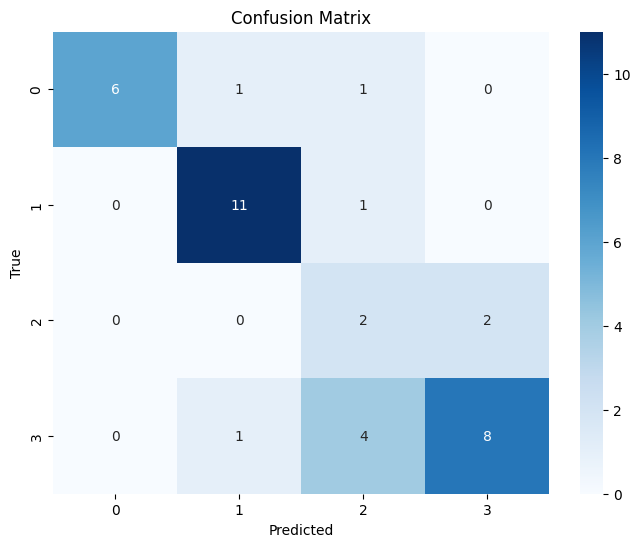

In [100]:
#@title # Perform predictions and check prediction scores

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Predictions
y_pred = final_rf.predict(X_test)
y_prob = final_rf.predict_proba(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# ROC-AUC
print("ROC-AUC (OvR):", roc_auc_score(y_test, y_prob, multi_class='ovr'))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [93]:
#@title Find and view most important features

import pandas as pd
import numpy as np

feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": final_rf.feature_importances_
})

feat_imp = feat_imp.sort_values("importance", ascending=False)

print("Most Important features for prediction")
print(feat_imp.head(15))

print(f"\nLeast important features for prediction")
print(feat_imp.tail(15))


Most Important features for prediction
                                feature  importance
56          night_peak_variability_beam    0.040251
88              daily pellets_bandit100    0.033732
83              total_pellets_bandit100    0.030452
86              retrievaltime_bandit100    0.028394
31                   recordinghours_fr1    0.027495
84                total_pokes_bandit100    0.026183
45            %grazingpellets_night_fr1    0.025776
72                peak_variability_beam    0.023691
26                     %mealpellets_fr1    0.020795
34            left poke with pellet_fr1    0.019509
27                  %grazingpellets_fr1    0.018636
78   max_peak_to_valley_difference_beam    0.017758
102                      right_poke_pr1    0.017356
120         session_length_bandit100_rl    0.017129
25                         poketime_fr1    0.016415

Least important features for prediction
                       feature  importance
136           beta_bandit80_rl    0.001906
37

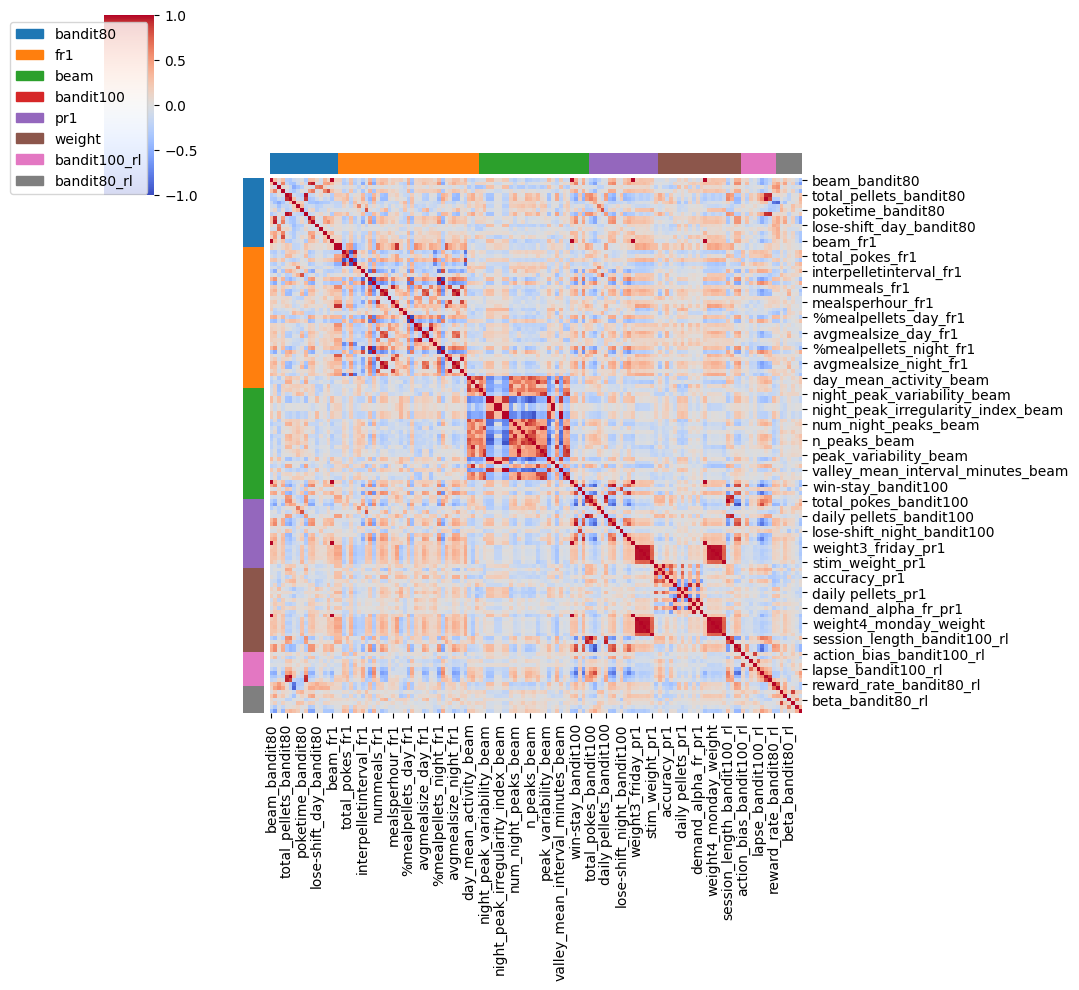

Highly correlated features: ['total_pokes_bandit80', 'daily pellets_bandit80', 'win-stay_day_bandit80', 'win-stay_night_bandit80', 'beam_fr1', 'left_poke_fr1', 'accuracy_fr1', 'pokesperpellet_fr1', '%mealpellets_fr1', '%grazingpellets_fr1', 'avgmealduration_fr1', 'mealsperhour_fr1', 'daily_pellets_fr1', '%mealpellets_day_fr1', '%grazingpellets_day_fr1', 'avgmealsize_day_fr1', 'avgmealduration_day_fr1', 'mealsperhour_day_fr1', '%mealpellets_night_fr1', '%grazingpellets_night_fr1', 'avgmealsize_night_fr1', 'avgmealduration_night_fr1', 'mealsperhour_night_fr1', 'accuracy_night_fr1', 'day_peak_variability_beam', 'day_peak_mean_interval_minutes_beam', 'night_peak_mean_interval_minutes_beam', 'night_peak_irregularity_index_beam', 'day_valley_mean_interval_minutes_beam', 'night_valley_mean_interval_minutes_beam', 'num_day_peaks_beam', 'num_night_peaks_beam', 'num_day_valleys_beam', 'num_night_valleys_beam', 'n_peaks_beam', 'n_valleys_beam', 'peak_mean_height_beam', 'peak_max_height_beam', 'pe

In [94]:
# @title # Correlation Matrix

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Build groups for features linked to


### Drop Keys and object columns ###
pca_df = df_all.drop(columns = merge_keys)
#pca_df = pd.concat([X_train, X_test])
drops = pca_df.select_dtypes(include=['object', 'bool']).columns
pca_df.drop(columns = drops, inplace=True)


# Plot correlation matrix to understand highly linked features
# Correlation matrix
corr = pca_df.corr()

groups = df_meta["session_type"].unique()
palette = sns.color_palette("tab10", n_colors=len(groups))

# Build a mapping: group -> color
group_colors = {}
for g, color in zip(groups, palette):
    group_colors[g] = color



col_colors = [group_colors[g] for g in df_meta["session_type"]]



sns.clustermap(corr, row_colors=col_colors, col_colors=col_colors,
               row_cluster=False, col_cluster=False, cmap="coolwarm", annot=False)



handles = [mpatches.Patch(color=color, label=grp) for grp, color in group_colors.items()]
plt.legend(handles=handles, bbox_to_anchor=(1,1))

plt.show()


""" This kinda works
# Create a feature -> group mapping
feature_to_group = dict(zip(df_meta["column_name"], df_meta["session_type"]))

# Replace tick labels with group names
xlabels = [feature_to_group[col] for col in corr.columns]
ylabels = [feature_to_group[row] for row in corr.index]

plt.figure(figsize=(6,6))
sns.heatmap(corr, xticklabels=xlabels, yticklabels=ylabels,
            cmap="coolwarm", annot=False, fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Feature-level correlation with group x-axis labels")
plt.tight_layout()
plt.show()
"""


#Drops high correlation data
# Find upper correlatives
threshold = 0.95
corr_matrix_abs = correlation_matrix.corr().abs()
upper_tri = corr_matrix_abs.where(pd.DataFrame(np.triu(np.ones(corr_matrix_abs.shape), k=1),
                                                columns=corr_matrix_abs.columns,
                                           index=corr_matrix_abs.index).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
print(f"Highly correlated features: {to_drop}")
#pca_df = pca_df.drop(columns=to_drop)



In [95]:
#@title # Format data for PCA
#@markdown use features with a score > above a certain threshold


####### Format data into PCA ready format #######

### Drop Keys and object columns ###
#pca_df = df_all.drop(columns = merge_keys)
#pca_df = pd.concat([X_train, X_test])
#drops = pca_df.select_dtypes(include=['object', 'bool']).columns
#pca_df.drop(columns = drops, inplace=True)

# find most important features
##non_feat = feat_imp[feat_imp['importance'] < 0.02]
#non_feat_drops = list(non_feat['feature'])
#print(non_feat_drops)
#cols_to_drop = [c for c in non_feat_drops if c in pca_df.columns]
#pca_df.drop(columns=cols_to_drop, inplace=True)




features = pca_df.select_dtypes(include=['int64', 'float64']).columns
print(len(features))
print(features)

### Standardize the scale ###
x = pca_df.loc[:, features].values
x = StandardScaler().fit_transform(x)

feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
pca_df = pd.DataFrame(x, columns=feat_cols)


### Check the data ###
df_prof(pca_df)
pca_df.head()



140
Index(['beam_bandit80', 'win-stay_bandit80', 'lose-shift_bandit80',
       'peakaccuracy_bandit80', 'total_pellets_bandit80',
       'total_pokes_bandit80', 'pokesperpellet_bandit80',
       'retrievaltime_bandit80', 'poketime_bandit80', 'daily pellets_bandit80',
       ...
       'session_length_bandit80_rl', 'total_rewards_bandit80_rl',
       'reward_rate_bandit80_rl', 'correct_port_rate_bandit80_rl',
       'action_bias_bandit80_rl', 'alpha_bandit80_rl', 'beta_bandit80_rl',
       'bias_bandit80_rl', 'lapse_bandit80_rl', 'best_loss_bandit80_rl'],
      dtype='object', length=140)
Number of rows: 122
Number of columns: 140
         Column DataType  Percent_Null  Number_Unique
0      feature0  float64           0.0             64
1      feature1  float64           0.0            121
2      feature2  float64           0.0            109
3      feature3  float64           0.0            103
4      feature4  float64           0.0             86
..          ...      ...           ...

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature130,feature131,feature132,feature133,feature134,feature135,feature136,feature137,feature138,feature139
0,-0.111895,1.598639,0.232532,1.044162,0.284385,-0.018686,-0.736692,-1.715123,-0.593755,-0.021253,...,-0.000080,0.773811,1.309985,1.150118,-0.276130,0.487021,-0.517756,-0.209343,-0.897099,-2.047676
1,-0.576462,0.818393,-0.581157,-0.503308,-0.268083,-0.646554,-1.061608,-1.715123,0.673912,-0.568376,...,-0.632773,-0.292019,0.617634,0.397318,-0.825058,0.620406,-0.757895,-1.204300,-1.037971,0.200517
2,3.962007,1.091182,-1.563531,0.303435,-0.949459,-0.945999,-0.110555,2.225461,1.760483,-1.080811,...,-0.992922,-1.377587,-0.865049,-0.248554,1.220978,0.948606,-0.701465,1.056397,-0.636282,0.112313
3,-0.433518,1.083489,-0.060706,1.010374,-0.286498,-0.443704,-0.469410,0.151469,-0.050469,-0.575807,...,-0.428365,0.142208,1.028549,1.160304,0.497811,-0.110165,-0.619532,0.448142,-1.037971,-0.616238
4,-0.647934,0.564220,0.815030,-1.102884,-1.778160,-1.998885,-1.053317,0.649227,-0.050469,-0.863344,...,-2.014966,-1.634175,0.941917,0.421150,0.658736,0.948606,-0.669414,0.865703,-0.275543,0.089558


Explained variability per principal component: [0.19615371 0.10694063]


/tmp/ipython-input-992806721.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(targets))


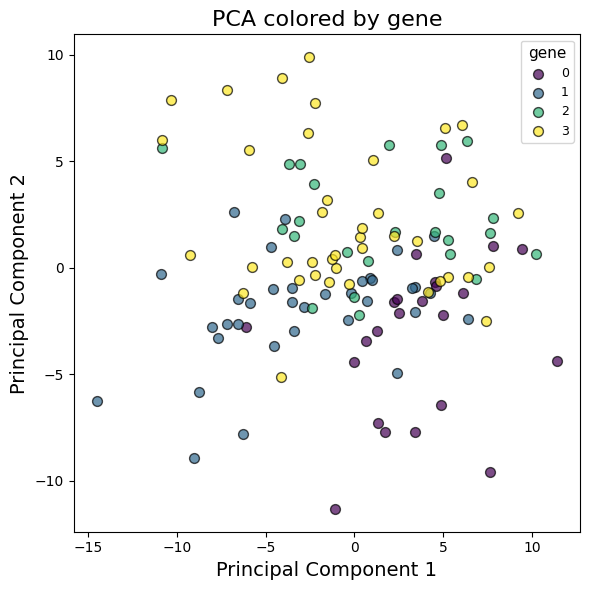

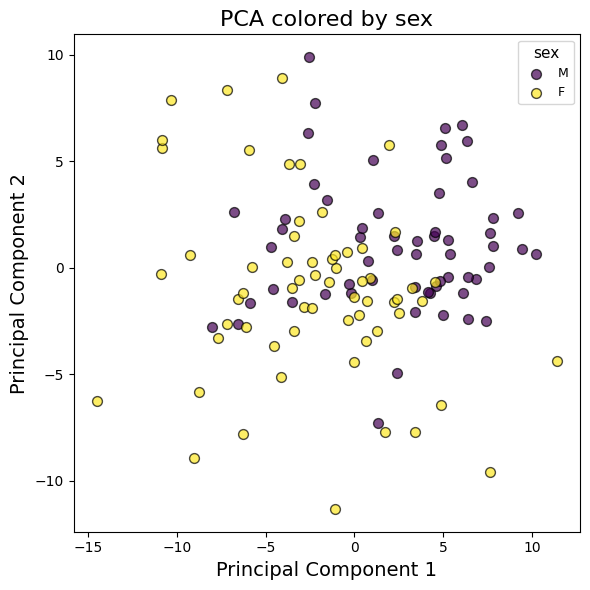

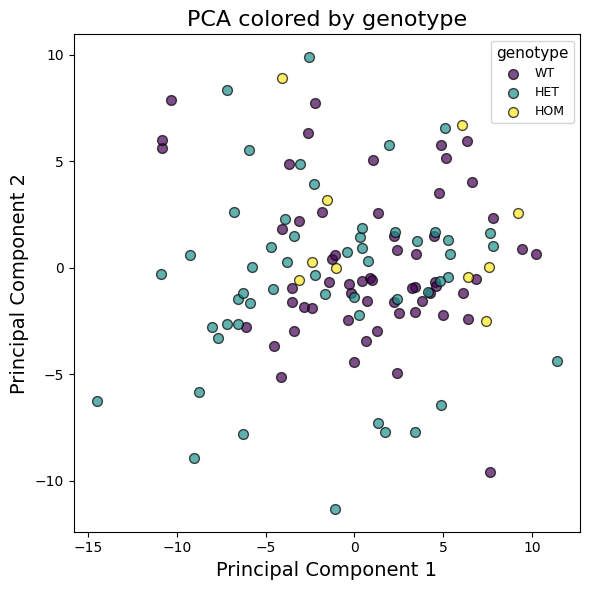

In [96]:
#@title # Conduct PCA Plotting Colored by Various Categoricals

####### PCA Plotting #######
pca = PCA(n_components=2)
clustering_df_pca = pca.fit_transform(pca_df)

clustering_df_pca = pd.DataFrame(data = clustering_df_pca,
                                 columns = ['principal component 1', 'principal component 2'])

print('Explained variability per principal component: {}'.format(pca.explained_variance_ratio_))


# Colummns for coloring
categorical_columns = ['gene', 'sex', 'genotype']

for cat_col in categorical_columns:
    plt.figure(figsize=(6,6))
    plt.title(f"PCA colored by {cat_col}", fontsize=16)
    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)

    ### Get unique groups for column ###
    targets = df_all[cat_col].dropna().unique()

    # Generate colors
    cmap = plt.cm.get_cmap('viridis', len(targets))
    colors = [cmap(i) for i in range(len(targets))]

    ### Scatter for each group ###
    for i, target in enumerate(targets):
        indicesToKeep = df_all[cat_col] == target
        plt.scatter(
            clustering_df_pca.loc[indicesToKeep, 'principal component 1'],
            clustering_df_pca.loc[indicesToKeep, 'principal component 2'],
            color=colors[i],
            s=50,
            alpha=0.7,
            edgecolors='k',
            label=str(target)
        )

    plt.legend(title=cat_col, fontsize=9, title_fontsize=11)
    plt.tight_layout()
    plt.show()

# Create K-Cluster Elbow Plot to Prepare Discovery of Clusters

In [ ]:
####### Explore how many K clusters #######

# Initialize variables for Elbow Method
inertia = []
K_range = range(2, 11) # Testing 2 to 10 clusters

# Iterate over potential numer of clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=25).fit(pca_df)
    inertia.append(kmeans.inertia_) # Within-cluster sum of squares
# Plot the Elbow Method
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)', fontsize = 15)
plt.ylabel('Within-Cluster Sum of Squares)', fontsize=15)
plt.grid(True)

# Perform the clustering using K from Above

Text(0, 0.5, 'Principal Component 2')

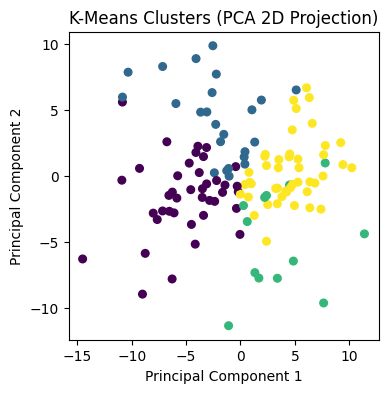

In [101]:
# Perform k-means clustering and save
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(pca_df)

# PCA for visualization
pca = PCA(n_components=2)
clustering_df_pca = pca.fit_transform(pca_df)

# Plot our pca data colored by clusters
plt.figure(figsize=(4,4))
plt.scatter(clustering_df_pca[:, 0], clustering_df_pca[:, 1], c=labels,
            cmap='viridis', s=30)
plt.title('K-Means Clusters (PCA 2D Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')